In [65]:
!pip install -r requirements.txt

     |████████████████████████████████| 60.5 MB 2.3 MB/s eta 0:00:01


# Get Data From API

## Generic Info
- How many breeds?
- How many images for each breed?

Save the information to a local file (`breeds.txt`) so that no need to request API next time

In [ ]:
%reset

import requests

In [14]:
def process_breeds():
    req = requests.get("https://dog.ceo/api/breeds/list/all")
    breeds_set = req.json()['message']
    breed_names = list(breeds_set.keys())

    print("Num of different (main) breeds:", len(breed_names))

    breeds = []
    for i in range(len(breed_names)):
        breed = breed_names[i]
        req_str = "https://dog.ceo/api/breed/{0}/images".format(breed)
        req = requests.get(req_str)

        breeds.append((breed, len(req.json()['message'])))

    for i in range(5):
        print(breeds[i])

    # Save to file
    f = open("breeds.txt", "w")
    f.write("breed,count\n")

    for i in range(len(breeds)):
        line = "{0},{1}\n".format(breeds[i][0], breeds[i][1])
        f.write(line)

    f.close()

process_breeds()

Num of different (main) breeds: 95
('affenpinscher', 150)
('african', 169)
('airedale', 202)
('akita', 9)
('appenzeller', 151)


## Download Image Data
There are 18k images for 95 breeds in total from the API.

Since no limit on number of concurrent requests from the server, use multithreading for downloading the images. It should take a total of less than 5 mins.

### Organisation of images downloaded:
The data are downloaded to `./dog/[breed_name]/[breed_name]_xxx.jpg` where `[breed_name]` is the dog's breed and `xxx` is a 3-digit int from 000 to 999

In [ ]:
%reset

import os
import requests
import threading
import urllib

In [5]:
def download_imgs(breeds):
    img_count = 0

    if not os.path.exists('dog'):
        os.makedirs('dog')

    start_down = False

    for breed in breeds:
        if breed == "retriever":
            start_down = True

        if not start_down:
            continue

        path_str = 'dog/' + breed
        if not os.path.exists(path_str):
            os.makedirs(path_str)

        print("Start for breed", breed)
        req_str = "https://dog.ceo/api/breed/{0}/images".format(breed)
        resp = requests.get(req_str).json()

        img_sources = resp['message']
        for i in range(len(img_sources)):

            source = img_sources[i]
            img_path = "{0}/{1}_{2:03}.jpg".format(path_str, breed, i)

            #urllib.request.urlretrieve(source, img_path)
            create_thread_for_download(source, img_path)

            img_count += 1

        print("Download all images for breed {0}.".format(breed))

    print("Success downloading all {0} images.".format(img_count))


# Use multithreading for download images
def download_by_req(source, img_path):
    urllib.request.urlretrieve(source, img_path)


def create_thread_for_download(source, img_path):
    download_thread = threading.Thread(target=download_by_req, args=(source, img_path))
    download_thread.start()

# download_imgs(breed_names)

# Resize all images
All images will be center-cropped and resized to dimension 224 x 224 (dimensions can be changed later)

In [101]:
%reset

from tqdm import tqdm
from PIL import Image

import os

In [102]:
breed_names_used = {'bulldog', 'hound', 'mountain', 'poodle', 'retriever', 'schnauzer', 'setter', 'sheepdog', 'spaniel', 'terrier'}
breed_names_dict = {}
label = 0
for breed in breed_names_used:
    breed_names_dict[breed] = label
    label += 1
print(breed_names_dict)

{'schnauzer': 0, 'sheepdog': 1, 'poodle': 2, 'bulldog': 3, 'hound': 4, 'spaniel': 5, 'retriever': 6, 'mountain': 7, 'terrier': 8, 'setter': 9}


In [103]:
# resize all images in all folders to be of the same dimension
def resize_all_imgs(breed_names_dict):
    for breed in breed_names_dict:
        path_str = 'dog/' + breed
        path_new_str = 'new_dog/' + breed
        if not os.path.exists(path_new_str):
            os.makedirs(path_new_str)

        num_files = len([f for f in os.listdir(path_str) if os.path.isfile(os.path.join(path_str, f))])
        for i in tqdm(range(num_files)):
            img_path = "{0}/{1}_{2:03}.jpg".format(path_str, breed, i)
            img_path_new = "{0}/{1}_{2:03}.jpg".format(path_new_str, breed, i)

            img = Image.open(img_path)
            size = min(img.size)
            hmargin = (img.size[0] - size) // 2
            vmargin = (img.size[1] - size) // 2
            img = img.crop((hmargin, vmargin, size+hmargin, size+vmargin))
            img = img.resize((224, 224))
            img = img.convert('RGB')
            img.save(img_path_new)

resize_all_imgs(breed_names_dict)

100%|██████████| 471/471 [00:04<00:00, 111.14it/s]


## Generate csv containing image_name, label pairs

In [104]:
def generate_csv(breed_names_dict):
    csv_file = open("dog_data.csv", "w")
    csv_file.write("image_name,label\n")

    for breed in breed_names_dict:
        path_str = 'new_dog/' + breed
        
        num_files = len([f for f in os.listdir(path_str) if os.path.isfile(os.path.join(path_str, f))])
        for i in range(0, num_files):
            img_path = "{0}/{1}_{2:03}.jpg".format(path_str, breed, i)
            csv_file.write("{0},{1}\n".format(img_path, breed_names_dict[breed]))

    csv_file.close()

generate_csv(breed_names_dict)

# Understand data

## TODO:
- [ ] Choose the appropriate number of labels
- [ ] Understand the different sizes of images

In [34]:
%reset

import matplotlib.pyplot as plt
import pandas as pd

In [35]:
dogs = pd.read_csv("breeds.txt", sep=",")

In [36]:
# descriptive statistics:
print("Total breed numbers:", len(dogs))
print("Total image numbers:", dogs["count"].sum())

Total breed numbers: 95
Total image numbers: 18225


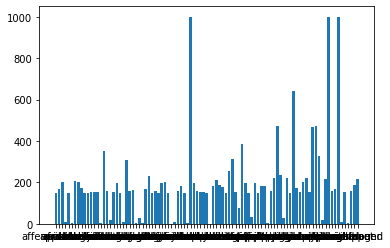

In [37]:
plt.bar(dogs["breed"], height=dogs["count"])
plt.show()

In [38]:
dogs = dogs.sort_values("count", ascending=0)

In [39]:
dogs.head(20)

,breed,count
88,terrier,1000
85,spaniel,1000
42,hound,1000
74,retriever,639
81,setter,471
69,poodle,471
80,schnauzer,466
58,mountain,387
15,bulldog,350
82,sheepdog,328


Consider the first k labels(breeds) with most number of images:


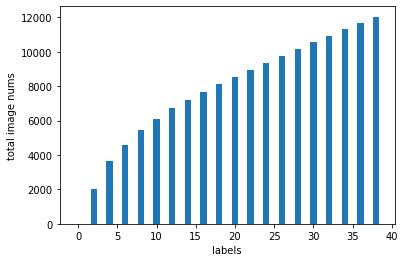

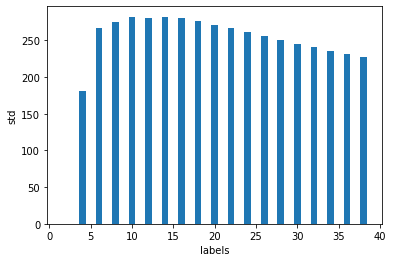

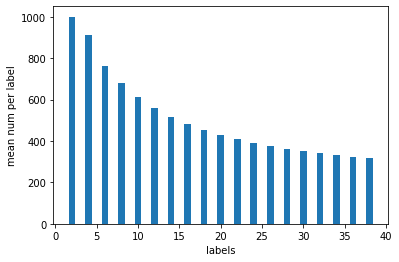

In [40]:
first_x = [*range(0,40,2)]

cummu_sum = [dogs["count"][:x].sum() for x in first_x]
cummu_sd = [dogs["count"][:x].std() for x in first_x]
cummu_mean = [dogs["count"][:x].mean() for x in first_x]

print("Consider the first k labels(breeds) with most number of images:")

fig, ax = plt.subplots()
ax.set_ylabel('total image nums')
ax.set_xlabel('labels')
plt.bar(first_x, cummu_sum)


fig, ax = plt.subplots()
ax.set_ylabel('std')
ax.set_xlabel('labels')
plt.bar(first_x, cummu_sd)

fig, ax = plt.subplots()
ax.set_ylabel('mean num per label')
ax.set_xlabel('labels')
plt.bar(first_x, cummu_mean)


plt.show()

# Save downloaded images as pytorch model

In [105]:
%reset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from skimage.io import imread, imshow
from skimage.util import img_as_ubyte
import torch
from tqdm import tqdm

In [106]:
data = pd.read_csv("dog_data.csv")
data.head()
all_img = []
for image_path in tqdm(data["image_name"]):
    img = imread(image_path)
    all_img.append(np.array(img, dtype=np.uint8))

train_x = np.stack(all_img)
train_y = data["label"].values
train_x.shape, train_y.shape

100%|██████████| 6112/6112 [00:13<00:00, 452.51it/s]


((6112, 224, 224, 3), (6112,))

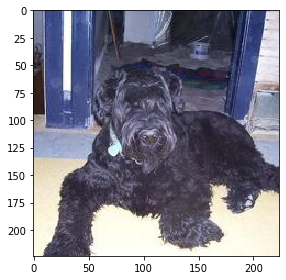

In [107]:
imshow(train_x[np.random.choice(train_x.shape[0])])

In [108]:
unaug_data = torch.from_numpy(train_x).float()
unaug_data = unaug_data.permute(0, 3, 1, 2).contiguous()
unaug_label = torch.from_numpy(train_y).long()

unaug_data.size(), unaug_label.size()

(torch.Size([6112, 3, 224, 224]), torch.Size([6112]))

In [109]:
p = Path("data/")
p.mkdir(parents=True, exist_ok=True)

torch.save(unaug_data, 'data/unaug_data_large.pt')
torch.save(unaug_label, 'data/unaug_label_large.pt')

# Perform image augmentation to downloaded images

Augmentations include rotations, shifting, flipping, adding noise and using cutmix

In [71]:
%reset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.io import imread, imshow
from skimage.transform import rescale, resize, rotate
from skimage.util import img_as_ubyte, random_noise
import torch
from torch import nn
from tqdm import tqdm

In [72]:
data = pd.read_csv("dog_data.csv")
data.head()
all_img = []
for image_path in tqdm(data["image_name"]):
    img = imread(image_path)
    all_img.append(np.array(img, dtype=np.uint8))

train_x = np.stack(all_img)
train_y = data["label"].values
train_x.shape, train_y.shape

100%|██████████| 6112/6112 [00:06<00:00, 876.05it/s] 


((6112, 224, 224, 3), (6112,))

In [73]:
label, counts = np.unique(train_y, return_counts=True)
y_count = dict(zip(label, counts))
y_count

{0: 466,
 1: 328,
 2: 471,
 3: 350,
 4: 1000,
 5: 1000,
 6: 639,
 7: 387,
 8: 1000,
 9: 471}

In [74]:
def rand_bbox(size, lamb):
    """ Generate random bounding box 
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter, sampled from Beta distribution
    Returns:
        - Bounding box
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int32(W * cut_rat)
    cut_h = np.int32(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [75]:
def generate_cutmix_image(image_batch, image_batch_labels, beta):
    """ Generate a CutMix augmented image from a batch 
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    """
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    rand_index = np.random.permutation(len(image_batch))
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0].shape, lam)
    image_batch_updated = image_batch.copy()
    image_batch_updated[:, bbx1:bbx2, bby1:bby2, :] = image_batch[rand_index, bbx1:bbx2, bby1:bby2, :]
    
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[1] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1. - lam)
    
    return image_batch_updated, label

In [76]:
cut_mix_img, cut_mix_labels = generate_cutmix_image(train_x, train_y, 0.5)

3.606305803571429


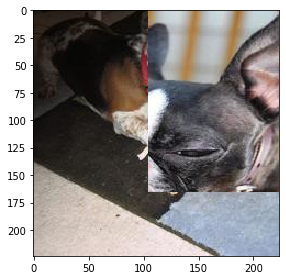

In [79]:
idx = np.random.choice(cut_mix_img.shape[0])
imshow(cut_mix_img[idx])
print(cut_mix_labels[idx])

In [80]:
# Ref:
# https://towardsdatascience.com/image-augmentation-with-skimage-python-7f53f1b0eeb5
def get_aug_img(img, multiplier):
    fs = [
        lambda img: img,
        lambda img: np.fliplr(img),
        lambda img: img_as_ubyte(rotate(img, angle=45, mode='wrap')),
        lambda img: img_as_ubyte(random_noise(img, var=0.2**2)),
        lambda img: np.flipud(img),
        lambda img: img_as_ubyte(rotate(img, angle=30, mode='wrap')),
        lambda img: rescale(img, 1.1)
    ]

    return (fs[i](img) for i in range(multiplier))
    

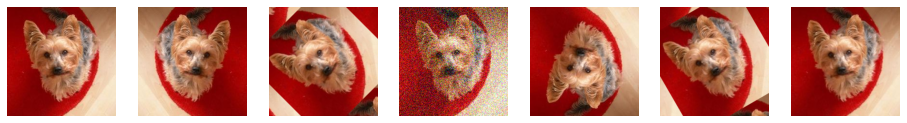

In [82]:
# Test all 7 types of augmentations
fig, ax = plt.subplots(nrows = 1, ncols = 7, figsize = (16, 16))
idx = np.random.choice(train_x.shape[0])

for i, aug in enumerate(get_aug_img(img=train_x[idx], multiplier=7)):
    ax[i].imshow(aug)
    ax[i].axis('off')

In [85]:
# balanced augmentation
balanced_imgs = []
balanced_x = []
balanced_y = []

w = 32

for i in tqdm(range(train_x.shape[0])):
    img, label = train_x[i], train_y[i]
    
    # multiplier round to nearest, such as each class around 2000 instances
    aug_multiplier = int(2000 / y_count[label] + 0.5)
    for img_aug in get_aug_img(img=img, multiplier=aug_multiplier):
        balanced_imgs.append(resize(img_aug, (w, w)))
        balanced_y.append(label)

for i in tqdm(range(cut_mix_img.shape[0])):
    img, label = cut_mix_img[i], cut_mix_labels[i]
    balanced_imgs.append(resize(img, (w, w)))
    balanced_y.append(label)

balanced_x = np.stack(balanced_imgs)
balanced_y = np.array(balanced_y)
balanced_x.shape, balanced_y.shape

100%|██████████| 6112/6112 [00:26<00:00, 233.38it/s]


((25664, 32, 32, 3), (25664,))

In [88]:
# Show the augmented number for each label
label, counts = np.unique(balanced_y, return_counts=True)
y_count_balanced = dict(zip(label, counts))
y_count_balanced

{0.0: 1899,
 0.3936941964285714: 36,
 0.6063058035714286: 27,
 0.7873883928571428: 33,
 1.0: 1988,
 1.1810825892857142: 27,
 1.2126116071428572: 38,
 1.3936941964285714: 20,
 1.5747767857142856: 85,
 1.6063058035714286: 31,
 1.7873883928571428: 18,
 1.8189174107142858: 26,
 1.968470982142857: 74,
 2.0: 1917,
 2.1810825892857144: 45,
 2.212611607142857: 17,
 2.3621651785714284: 39,
 2.393694196428571: 28,
 2.4252232142857144: 82,
 2.5747767857142856: 51,
 2.606305803571429: 20,
 2.755859375: 28,
 2.787388392857143: 62,
 2.8189174107142856: 58,
 2.9684709821428568: 33,
 3.0: 2121,
 3.0315290178571432: 77,
 3.149553571428571: 73,
 3.1810825892857144: 91,
 3.212611607142857: 61,
 3.362165178571429: 19,
 3.393694196428571: 71,
 3.4252232142857144: 49,
 3.5432477678571423: 36,
 3.5747767857142856: 50,
 3.606305803571429: 57,
 3.6378348214285716: 47,
 3.755859375: 66,
 3.787388392857143: 58,
 3.818917410714286: 72,
 3.968470982142857: 28,
 4.0: 2157,
 4.031529017857143: 33,
 4.149553571428571

In [90]:
from pathlib import Path

p = Path("data/")
p.mkdir(parents=True, exist_ok=True)

balanced_data = torch.from_numpy(balanced_x).float()
balanced_data = balanced_data.permute(0, 3, 1, 2).contiguous()
balanced_label = torch.from_numpy(balanced_y).long()

torch.save(balanced_data, f"data/balan_cutmix_data_{w}.pt")
torch.save(balanced_label, f"data/balan_cutmix_label_{w}.pt")
balanced_data.size(), balanced_label.size()

(torch.Size([25664, 3, 32, 32]), torch.Size([25664]))